# Particle Transformerで示されているJetClass DatasetのEDA

- ダウンロードは[こちら](https://zenodo.org/records/6619768)
- 結局研究に使っていない

In [1]:
import os
from typing import List, Tuple, Dict, Union, Any, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import yaml
import h5py
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split

In [2]:
N_ROOTFILES_LIMIT = 10
N_PARTICLES_LIMIT = 200 # ファイルから読み出す最大のパーティクル数
N_PARTICLES_LIMIT_ACTUAL = 100 # 実際にモデルに入力する最大のパーティクル数
prefix_flavours = [
    "HToBB",
    "HToCC",
    "HToGG",
    "HToWW2Q1L",
    "HToWW4Q",
    "TTBar",
    "TTBarLep",
    "WToQQ",
    "ZJetsToNuNu",
    "ZToQQ",
]


In [3]:
tree = uproot.open("/home/suzukiy/ftag/jetclass-dataset/rootfiles/HToBB_001.root")["tree"]
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
part_px              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_py              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_pz              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_energy          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_deta            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dphi            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0val           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0err           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzval           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzerr           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_charge          | std::

## トラック数の確認

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4.5))
for i in range(1):
    for label_idx, label in enumerate(prefix_flavours):
        arrays = uproot.open(f"/home/suzukiy/ftag/jetclass-dataset/rootfiles/{label}_000.root")["tree"].arrays(["jet_nparticles"], library="pd")
        ax.hist(arrays, bins=np.arange(120), histtype="step", label=label)
ax.set_xlabel("Number of particles")
ax.set_ylabel("Number of jets")
ax.text(0.02, 0.98, "JetClass Dataset, first 1M training jets", transform=ax.transAxes, va="top", ha="left", fontsize=11)
ax.set_xlim(0, 120)
ax.set_ylim(0, 5000)
ax.legend()
plt.show()

In [5]:
track_features_origin = [
    "part_px",
    "part_py",
    "part_pz",
    "part_deta",
    "part_dphi",
    "part_charge",
    "part_d0val",
    "part_d0err",
    "part_dzval",
    "part_dzerr",
]

tracks_features_processed = [
    "deta",
    "dphi",
    "pt",
    "d0",
    "dz",
    "qOverP",
    "d0_signed_significance",
    "z0_signed_significance",
]

jet_features = [
    "jet_eta",
    "jet_pt",
]

def calc_pt(px, py):
    return np.sqrt(px**2 + py**2)

def calc_qOverP(px, py, pz, charge):
    return charge / np.sqrt(px**2 + py**2 + pz**2)

def calc_signed_significance(val, err, eps=0.001):
    return val/(err + eps)

class ProcessWrapper:
    def __init__(self, dict_arrays, track_features_origin):
        self.dict_arrays = dict_arrays
        self.track_features_origin = track_features_origin

    @property
    def deta(self):
        return self.dict_arrays["part_deta"]
    
    @property
    def dphi(self):
        return self.dict_arrays["part_dphi"]

    @property
    def pt(self):
        return calc_pt(self.dict_arrays["part_px"], self.dict_arrays["part_py"])
    
    @property
    def qOverP(self):
        return calc_qOverP(self.dict_arrays["part_px"], self.dict_arrays["part_py"], self.dict_arrays["part_pz"], self.dict_arrays["part_charge"])
    
    @property
    def d0(self):
        return self.dict_arrays["part_d0val"]
    
    @property
    def dz(self):
        return self.dict_arrays["part_dzval"]
    
    @property
    def d0_signed_significance(self):
        return calc_signed_significance(self.dict_arrays["part_d0val"], self.dict_arrays["part_d0err"])
    
    @property
    def z0_signed_significance(self):
        return calc_signed_significance(self.dict_arrays["part_dzval"], self.dict_arrays["part_dzerr"])
    

def process_tracks(arrays, track_features_origin, tracks_features_processed)->Tuple[List[str], np.ndarray, np.ndarray]:
    dict_features = {}
    idx_d0_significance = tracks_features_processed.index("d0_signed_significance")
    for track_feature in track_features_origin:
        dict_features[track_feature] = ak.pad_none(arrays[track_feature], N_PARTICLES_LIMIT, axis=-1).to_numpy()

    mask = dict_features["part_px"].mask


    dict_features_processed = {}
    processor = ProcessWrapper(dict_features, track_features_origin)
    for track_feature in tracks_features_processed:
        dict_features_processed[track_feature] = getattr(processor, track_feature)

    processed_arrays = np.stack(list(dict_features_processed.values()), axis=-1).filled(np.nan) # (N, P, F)
    # decreacing order of abs(d0_signed_significance), nan is the smallest
    processed_arrays = np.where(np.isnan(processed_arrays), 0., processed_arrays)
    sorted_idx = np.argsort(np.abs(processed_arrays[:, :, idx_d0_significance]), axis=1)[:, ::-1, np.newaxis]
    processed_arrays = np.take_along_axis(processed_arrays, sorted_idx, axis=1)
    processed_arrays = processed_arrays[:, :N_PARTICLES_LIMIT_ACTUAL, :]
    # mask again
    mask = mask[:, :N_PARTICLES_LIMIT_ACTUAL]
    processed_arrays = np.where(mask[:, :, np.newaxis], np.nan, processed_arrays)

    return dict_features_processed.keys(), processed_arrays, mask

def process_tracks_dict(arrays, track_features_origin, tracks_features_processed)->Dict[str, np.ma.masked_array]:
    dict_features = {}
    for track_feature in track_features_origin:
        dict_features[track_feature] = ak.pad_none(arrays[track_feature], N_PARTICLES_LIMIT, axis=-1).to_numpy()

    dict_features_processed = {}
    processor = ProcessWrapper(dict_features, track_features_origin)
    for track_feature in tracks_features_processed:
        dict_features_processed[track_feature] = getattr(processor, track_feature)

    return dict_features_processed


def process_jets(arrays, jet_features, mask)->Tuple[List[str], np.ndarray]:
    dict_features = {}
    for jet_feature_names in jet_features:
        jet_feature_1d = arrays[jet_feature_names].to_numpy() # (N, )
        # (N,) -> (N, P), value==jet_feature_1d[i] where mask[i] is False
        jet_feature = np.tile(jet_feature_1d, (N_PARTICLES_LIMIT_ACTUAL, 1)).T # (N, P)
        jet_feature[mask] = np.nan
        dict_features[jet_feature_names] = jet_feature

    processed_jet_arrays = np.stack(list(dict_features.values()), axis=-1) # (N, P, F)
        
    return dict_features.keys(), processed_jet_arrays

def process_jets_dict(arrays, jet_features)->Dict[str, np.ma.masked_array]:
    dict_features = {}
    for jet_feature_names in jet_features:
        jet_feature_1d = arrays[jet_feature_names].to_numpy()
        dict_features[jet_feature_names] = jet_feature_1d

    return dict_features        

## 試しに読み出す

In [6]:
tree = uproot.open("/home/suzukiy/ftag/jetclass-dataset/rootfiles/HToBB_001.root")["tree"]
arrays = tree.arrays(track_features_origin, library="ak")
d0err = ak.pad_none(arrays["part_d0err"], N_PARTICLES_LIMIT, axis=-1).to_numpy()
z0err = ak.pad_none(arrays["part_dzerr"], N_PARTICLES_LIMIT, axis=-1).to_numpy()

In [7]:
tree = uproot.open("/home/suzukiy/ftag/jetclass-dataset/rootfiles/HToBB_000.root")["tree"]
arrays = tree.arrays(track_features_origin, library="ak")
dict_features_processed = process_tracks_dict(arrays, track_features_origin, tracks_features_processed)

## スケールの計算

In [ ]:
dict_arrays_compressed: Dict[str, List[np.ndarray]] = {}
dict_arrays_compressed_jet: Dict[str, List[np.ndarray]] = {}
for i in range(1):
    for label_idx, label in enumerate(tqdm(prefix_flavours)):
        arrays = uproot.open(f"/home/suzukiy/ftag/jetclass-dataset/rootfiles/{label}_000.root")["tree"].arrays(track_features_origin, library="ak")
        arrays_jet = uproot.open(f"/home/suzukiy/ftag/jetclass-dataset/rootfiles/{label}_000.root")["tree"].arrays(jet_features, library="ak")
        # print(f"{label}_{i:03d}.root")
        dict_features_processed = process_tracks_dict(arrays, track_features_origin, tracks_features_processed)
        dict_features_processed_jet = process_jets_dict(arrays_jet, jet_features)
        for feature_name, feature in dict_features_processed.items():
            if feature_name not in dict_arrays_compressed:
                dict_arrays_compressed[feature_name] = []
            dict_arrays_compressed[feature_name].append(feature.compressed())
        for feature_name, feature in dict_features_processed_jet.items():
            if feature_name not in dict_arrays_compressed_jet:
                dict_arrays_compressed_jet[feature_name] = []
            dict_arrays_compressed_jet[feature_name].append(feature)

for feature_name, feature in dict_arrays_compressed.items():
    dict_arrays_compressed[feature_name] = np.concatenate(feature)
    print(feature_name, dict_arrays_compressed[feature_name].shape)

for feature_name, feature in dict_arrays_compressed_jet.items():
    dict_arrays_compressed_jet[feature_name] = np.concatenate(feature)
    print(feature_name, dict_arrays_compressed_jet[feature_name].shape)

In [ ]:
df = pd.DataFrame(dict_arrays_compressed)
_mean, _std = df.mean(), df.std()

df_jet = pd.DataFrame(dict_arrays_compressed_jet)
_mean_jet, _std_jet = df_jet.mean(), df_jet.std()

# concat _mean with _mean_jet, _std with _std_jet
_mean = pd.concat([_mean_jet, _mean])
_std = pd.concat([_std_jet, _std])

import json

# save as json like: {"deta": {"mean": 0.1, "std": 0.2}, "dphi": {"mean": 0.1, "std": 0.2}, ...}
with open("../jetclass-dataset/scale_dict.json", "w") as f:
    json.dump({feature_name: {"mean": float(_mean[feature_name]), "std": float(_std[feature_name])} for feature_name in _mean.index}, f)

# save mean and std as npy
np.save("../jetclass-dataset/mean.npy", _mean)
np.save("../jetclass-dataset/std.npy", _std)

## train_datasetの作成

In [8]:
def shuffle_arrays(*arrays, random_state=42):
    p = np.random.RandomState(seed=random_state).permutation(len(arrays[0]))
    return [array[p] for array in arrays]

In [10]:
train_path = "../jetclass-dataset/processed/train.h5"

_mean = np.load("../jetclass-dataset/mean.npy")
_std = np.load("../jetclass-dataset/std.npy")

for i in tqdm(range(39, 100)):
    xs = []
    ys = []
    y_one_hots = []
    masks = []
    for label_idx, label in enumerate(prefix_flavours):
        arrays = uproot.open(f"/home/suzukiy/ftag/jetclass-dataset/rootfiles/{label}_{i:03d}.root")["tree"].arrays(track_features_origin, library="ak")
        arrays_jet = uproot.open(f"/home/suzukiy/ftag/jetclass-dataset/rootfiles/{label}_{i:03d}.root")["tree"].arrays(jet_features, library="ak")
        feature_names, x, mask = process_tracks(arrays, track_features_origin, tracks_features_processed)
        feature_names_jet, x_jet = process_jets(arrays_jet, jet_features, mask)

        x = np.concatenate([x_jet, x], axis=-1) # (N, P, F)
        x = (x - _mean) / _std # scale
        x[np.isnan(x)] = 0.0 # fill nan with 0.0

        y = np.full((x.shape[0], ), label_idx)
        y_one_hot = np.eye(len(prefix_flavours))[y]

        xs.append(x)
        ys.append(y)
        y_one_hots.append(y_one_hot)
        masks.append(mask)


    xs = np.concatenate(xs, axis=0)
    ys = np.concatenate(ys, axis=0)
    y_one_hots = np.concatenate(y_one_hots, axis=0)
    masks = np.concatenate(masks, axis=0)

    xs, ys, y_one_hots, masks = shuffle_arrays(xs, ys, y_one_hots, masks)

    # break

    if i == 0:
        with h5py.File(train_path, "w") as f:
            f.create_group("features")
            f.create_group("labels")
            f.create_group("labels_one_hot")
            f.create_group("masks")
    
    with h5py.File(train_path, "a") as f:
        f["features"].create_dataset(f"{i:03d}", data=xs)
        f["labels"].create_dataset(f"{i:03d}", data=ys)
        f["labels_one_hot"].create_dataset(f"{i:03d}", data=y_one_hots)
        f["masks"].create_dataset(f"{i:03d}", data=masks)

100%|██████████| 61/61 [1:11:19<00:00, 70.15s/it]


In [9]:
train_path = "../jetclass-dataset/processed/train.h5"
with h5py.File(train_path, "r") as f:
    for k in f["features"].keys():
        print(k, f["features"][k].shape)
        print(k, f["labels"][k].shape)

000 (1000000, 100, 10)
000 (1000000,)
001 (1000000, 100, 10)
001 (1000000,)
002 (1000000, 100, 10)
002 (1000000,)
003 (1000000, 100, 10)
003 (1000000,)
004 (1000000, 100, 10)
004 (1000000,)
005 (1000000, 100, 10)
005 (1000000,)
006 (1000000, 100, 10)
006 (1000000,)
007 (1000000, 100, 10)
007 (1000000,)
008 (1000000, 100, 10)
008 (1000000,)
009 (1000000, 100, 10)
009 (1000000,)


In [ ]:
from modules import data
import importlib
importlib.reload(data)

<module 'modules.data' from '/home/suzukiy/ftag/particlenet-ftag/modules/data.py'>

In [ ]:
train_path = "../jetclass-dataset/processed/train.h5"

dataloader = data.OutMemoryDataLoader(
    train_path,
    preload_factor=1000000,
    var_trks_all=tracks_features_processed,
    var_trks_use=tracks_features_processed,
    size = 10000000,
    is_jet_class=True,
).dataloader()

size 10000000 is used.
dataset length:  10
training data size: 10000000


In [ ]:
for i, (x, y) in enumerate(dataloader):
    print(x.shape, y.shape)
    if i == 0:
        break

torch.Size([1000000, 8, 100]) torch.Size([1000000])


## validation/test datasetの作成

In [18]:
# validation
validation_path = "../jetclass-dataset/processed/validation.h5"

_mean = np.load("../jetclass-dataset/mean.npy")
_std = np.load("../jetclass-dataset/std.npy")

for i in range(5):
    idx = 120 + i
    xs = []
    ys = []
    y_one_hots = []
    masks = []
    for label_idx, label in enumerate(tqdm(prefix_flavours)):
        arrays = uproot.open(f"/home/suzukiy/ftag/jetclass-dataset/rootfiles/val_5M/{label}_{idx:03d}.root")["tree"].arrays(track_features_origin, library="ak")
        arrays_jet = uproot.open(f"/home/suzukiy/ftag/jetclass-dataset/rootfiles/val_5M/{label}_{idx:03d}.root")["tree"].arrays(jet_features, library="ak")
        feature_names, x, mask = process_tracks(arrays, track_features_origin, tracks_features_processed)
        feature_names_jet, x_jet = process_jets(arrays_jet, jet_features, mask)

        x = np.concatenate([x_jet, x], axis=-1) # (N, P, F)
        x = (x - _mean) / _std # scale
        x[np.isnan(x)] = 0.0 # fill nan with 0.0

        y = np.full((x.shape[0], ), label_idx)
        y_one_hot = np.eye(len(prefix_flavours))[y]

        xs.append(x)
        ys.append(y)
        y_one_hots.append(y_one_hot)
        masks.append(mask)


    xs = np.concatenate(xs, axis=0)
    ys = np.concatenate(ys, axis=0)
    y_one_hots = np.concatenate(y_one_hots, axis=0)
    masks = np.concatenate(masks, axis=0)

    # xs, ys, masks = shuffle_arrays(xs, ys, masks)

    if i == 0:
        with h5py.File(validation_path, "w") as f:
            f.create_group("features")
            f.create_group("labels")
            f.create_group("labels_one_hot")
            f.create_group("masks")
    
    with h5py.File(validation_path, "a") as f:
        f["features"].create_dataset(f"{idx:03d}", data=xs)
        f["labels"].create_dataset(f"{idx:03d}", data=ys)
        f["labels_one_hot"].create_dataset(f"{idx:03d}", data=y_one_hots)
        f["masks"].create_dataset(f"{idx:03d}", data=masks)

100%|██████████| 10/10 [00:55<00:00,  5.58s/it]


In [19]:
# test
test_path = "../jetclass-dataset/processed/test.h5"

_mean = np.load("../jetclass-dataset/mean.npy")
_std = np.load("../jetclass-dataset/std.npy")

for i in range(20):
    idx = 100 + i
    xs = []
    ys = []
    y_one_hots = []
    masks = []
    for label_idx, label in enumerate(tqdm(prefix_flavours)):
        arrays = uproot.open(f"/home/suzukiy/ftag/jetclass-dataset/rootfiles/test_20M/{label}_{idx:03d}.root")["tree"].arrays(track_features_origin, library="ak")
        arrays_jet = uproot.open(f"/home/suzukiy/ftag/jetclass-dataset/rootfiles/test_20M/{label}_{idx:03d}.root")["tree"].arrays(jet_features, library="ak")
        feature_names, x, mask = process_tracks(arrays, track_features_origin, tracks_features_processed)
        feature_names_jet, x_jet = process_jets(arrays_jet, jet_features, mask)

        x = np.concatenate([x_jet, x], axis=-1) # (N, P, F)
        x = (x - _mean) / _std # scale
        x[np.isnan(x)] = 0.0 # fill nan with 0.0

        y = np.full((x.shape[0], ), label_idx)

        xs.append(x)
        ys.append(y)
        y_one_hots.append(y_one_hot)
        masks.append(mask)


    xs = np.concatenate(xs, axis=0)
    ys = np.concatenate(ys, axis=0)
    ys_one_hots = np.concatenate(y_one_hots, axis=0)
    masks = np.concatenate(masks, axis=0)

    # xs, ys, masks = shuffle_arrays(xs, ys, masks)

    if i == 0:
        with h5py.File(test_path, "w") as f:
            f.create_group("features")
            f.create_group("labels")
            f.create_group("labels_one_hot")
            f.create_group("masks")
    
    with h5py.File(test_path, "a") as f:
        f["features"].create_dataset(f"{idx:03d}", data=xs)
        f["labels"].create_dataset(f"{idx:03d}", data=ys)
        f["labels_one_hot"].create_dataset(f"{idx:03d}", data=y_one_hots)
        f["masks"].create_dataset(f"{idx:03d}", data=masks)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:03<00:00,  6.30s/it]


## 変数の分布の確認

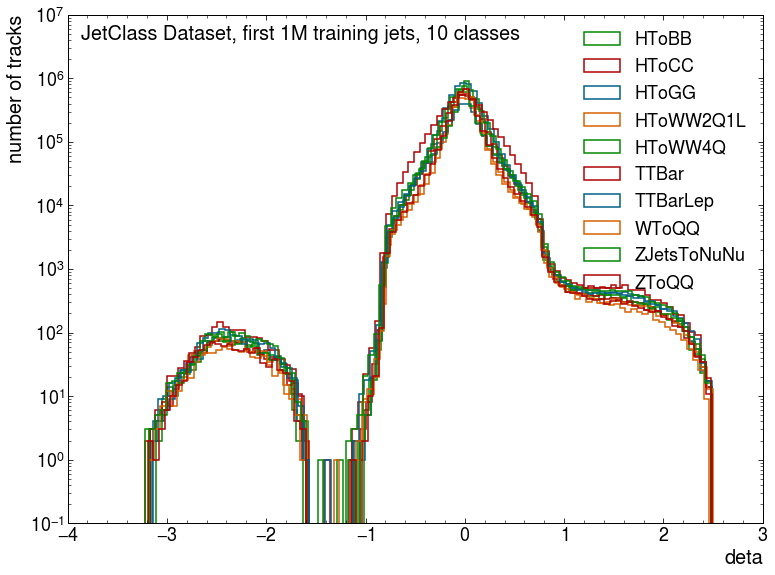

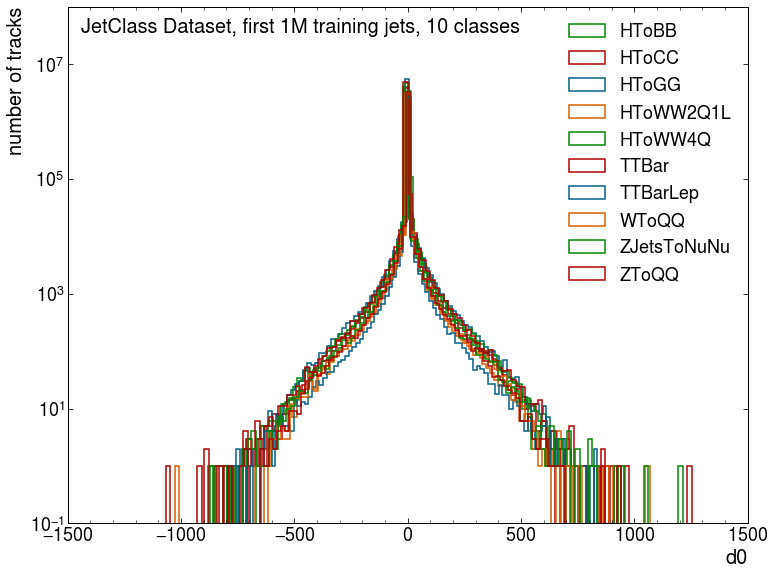

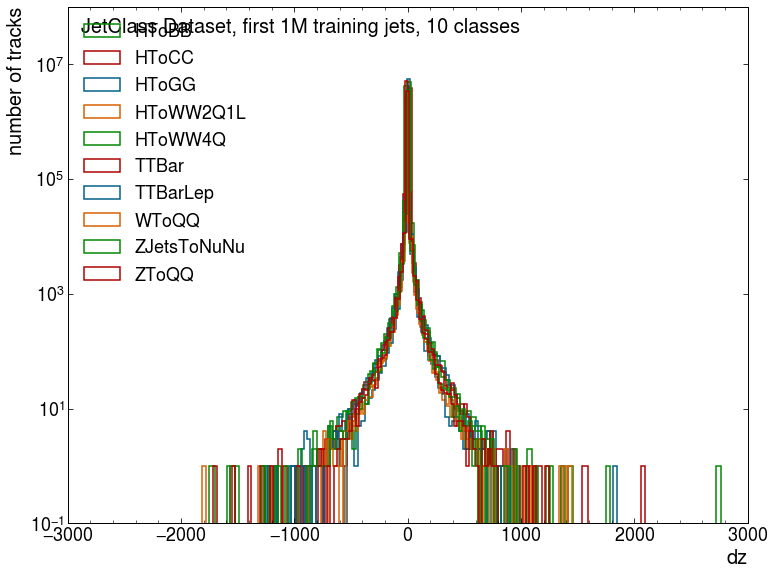

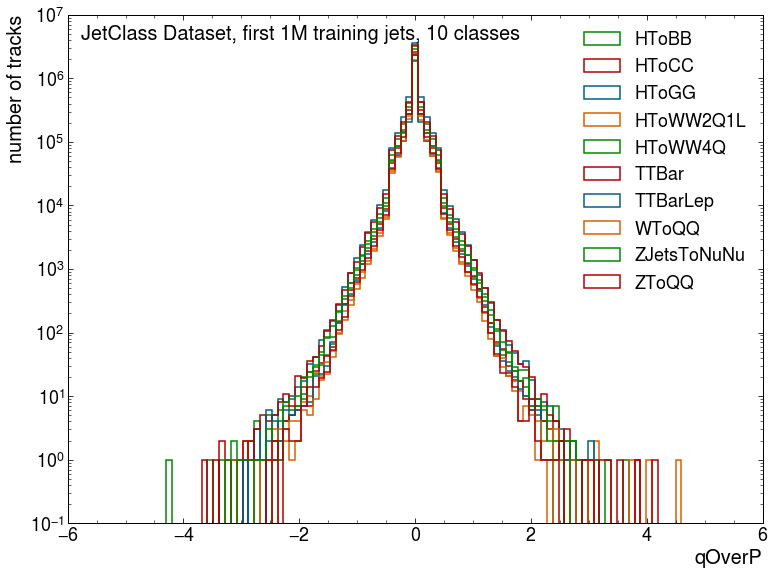

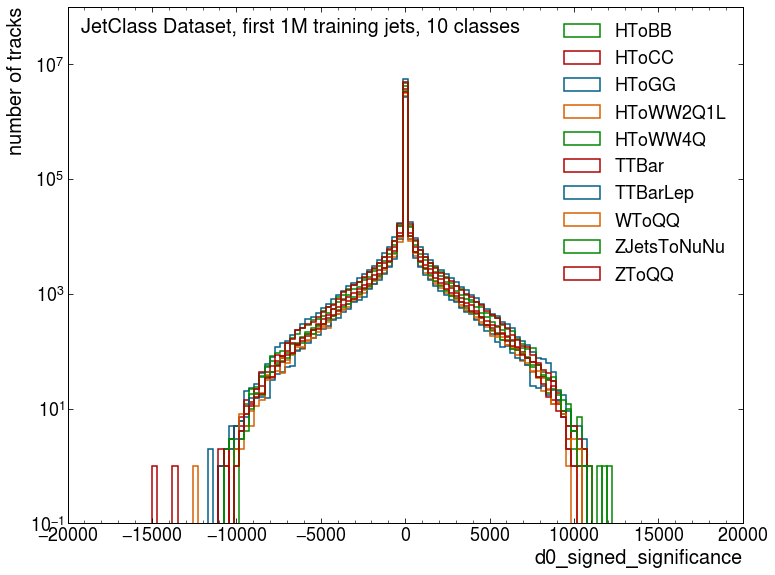

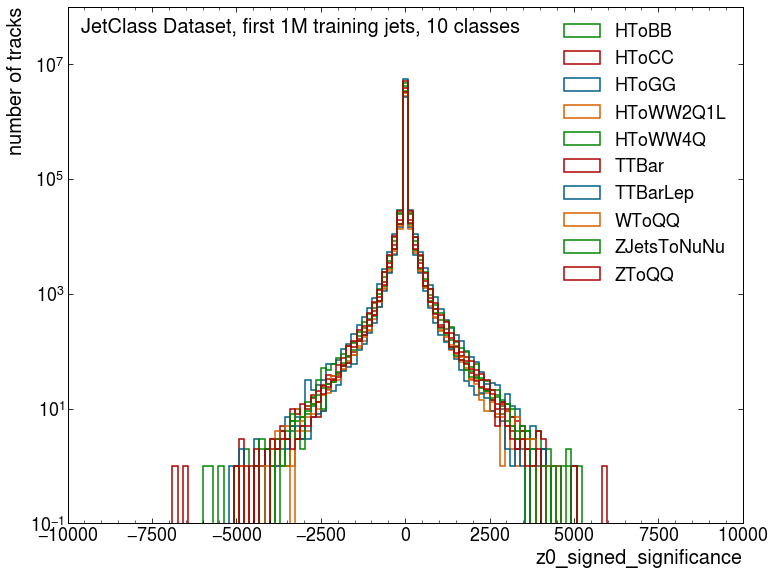

In [ ]:
import json
import matplotlib.pyplot as plt
import atlas_mpl_style as ampl

with open("../jetclass-dataset/scale_dict.json", "r") as f:
    feature_names_all = json.load(f).keys()

ampl.use_atlas_style()
for i, feature_name in enumerate(feature_names_all):
    fig, ax = plt.subplots()

    if feature_name == "d0_signed_significance":
        bins = np.linspace(-15000, 15000, 100)
    elif feature_name == "z0_signed_significance":
        bins = np.linspace(-7500, 7500, 100)
    elif feature_name == "qOverP":
        bins = np.linspace(-5, 5, 100)
    else:
        bins = 100
    for label_idx, label in enumerate(prefix_flavours):
        ax.hist(xs[ys==label_idx][:,:,i][~masks[ys==label_idx]].flatten(), bins=bins, histtype="step", label=label, linewidth=1.5)
    ax.text(0.02, 0.98, "JetClass Dataset, first 1M training jets, 10 classes", transform=ax.transAxes, va="top", ha="left", fontsize=20)
    ax.set_yscale("log")
    ampl.set_xlabel(feature_name, ax=ax)
    ampl.set_ylabel("number of tracks", ax=ax)
    ax.legend()
    # tight_layout
    plt.ticklabel_format(style="plain", axis="x")
    fig.tight_layout()
    plt.show()

# 試しに走らせる

In [ ]:
import os
from typing import Tuple, Dict, List, Union, Any, Optional
import argparse
import random
import warnings

import h5py
import yaml
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tqdm import tqdm

from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

import torch
from torch import optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchinfo import summary
from weaver.utils.nn.optimizer import ranger

from modules import data, eval, exec, fix_seed, MyParT, file_util

In [ ]:
prefix_flavours = [
    "HToBB",
    "HToCC",
    "HToGG",
    "HToWW2Q1L",
    "HToWW4Q",
    "TTBar",
    "TTBarLep",
    "WToQQ",
    "ZJetsToNuNu",
    "ZToQQ",
]

tracks_features_processed = [
    "deta",
    "dphi",
    "pt",
    "d0",
    "dz",
    "qOverP",
    "d0_signed_significance",
    "z0_signed_significance",
]

jet_features = [
    "jet_eta",
    "jet_pt",
]

features_all = tracks_features_processed + jet_features

(1000000, 200, 8)

In [ ]:
with open("./models/parT/JetClass-1M/config.yaml", "r") as f:
    config = yaml.safe_load(f)

config

In [ ]:
fix_seed.fix_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_loader = data.OutMemoryDataLoader(
    dir_path = os.path.join(config["dataset"]["data_path"], "train.h5"),
    preload_factor=1000000, # dummy
    var_trks_use=features_all,
    var_trks_all=features_all,
    size=config["dataset"]["train_size"],
    is_jet_class=True,
).dataloader()

In [ ]:
model = MyParT.MyParTTagger(
    **config["hyperparameters"]["model"],
).to(device)


optimizer = ranger.Ranger(
    model.parameters(),
    **config["hyperparameters"]["optimizer"]["params"]
)

class CustomLRDecay(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, total_iterations, last_epoch=-1):
        # 1M iterations = 100% 
        # 70% of 1M = 700k
        self.stable_iterations = 0.7 * total_iterations
        # Interval for exponential decay
        self.decay_interval = 20_000
        # Total number of decay steps from 70% to 100%
        self.total_decay_steps = (total_iterations - self.stable_iterations) / self.decay_interval
        # Calculate decay factor per step to reach 1% of original LR at the end
        self.decay_factor = 0.01 ** (1.0 / self.total_decay_steps)
        super(CustomLRDecay, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.stable_iterations:
            return [base_lr for base_lr in self.base_lrs]
        else:
            decay_steps = (self.last_epoch - self.stable_iterations) // self.decay_interval
            return [base_lr * (self.decay_factor ** decay_steps) for base_lr in self.base_lrs]

scheduler = CustomLRDecay(
    optimizer,
    total_iterations = config["hyperparameters"]["total_iterations"],
)

loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
summary(model, (
    (512, 10, 100), # features
    (512, 1, 100), # mask
    (512, 3, 100*100), # uu
    (512, 2, 100*100), # uu_idx
))

In [ ]:
iteration = 0
while True:
    iteration, train_loss, train_acc, train_y_test, train_y_pred = exec.train_parT_with_offline_loader(
        model = model,
        dataloader=train_loader,
        batch_size = config["hyperparameters"]["batch_size"],
        optimizer = optimizer,
        loss_fn = loss_fn,
        scheduler = scheduler,
        device = device,
        lorentz_idx={"deta": 2, "dphi": 3, "pt": 4},
        edge_config=config["dataset"]["edge_config"],
        scale_dict=None,
        scheduler_step="batch",
        use_mask=True,
        use_iteration=True,
        iteration=iteration,
    )
    print(f"train_loss: {train_loss}, train_acc: {train_acc}")
    print("iteration: ", iteration)
    if iteration >= config["hyperparameters"]["total_iterations"]:
        break